In [17]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split

## Dataset construction

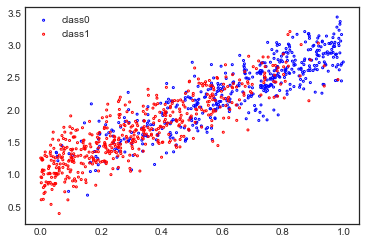

In [18]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,1000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 



plt.scatter(x0,y0,s=4,facecolors='none',edgecolors='b',label='class0') # class 0
plt.scatter(x1,y1,s=4,facecolors='none',edgecolors='r', label='class1') # class 1
plt.legend()
plt.show()


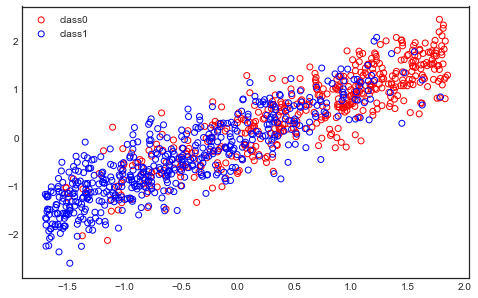

In [19]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))
Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)

X = np.asarray(X)
Y = np.asarray(Y)

X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

X.shape , Y.shape



plt.figure(figsize=(8,5))
plt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='r',label='class0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='b',label='class1')
plt.legend()
plt.show()

## Neural Network Construction to apply variational inference

We now construct a neural network with two hidden layes and initialize random weights without biasses between each layer.
Between the layers we will use a $tanh$ activatiopn function and use a sigmoid for the output

In [20]:


def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)



In [21]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [22]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = 445.77: 100%|██████████| 50000/50000 [01:34<00:00, 531.53it/s]
Finished [100%]: Average Loss = 445.8


CPU times: user 1min 14s, sys: 4.5 s, total: 1min 19s
Wall time: 1min 46s


In [23]:
trace = approx.sample(draws=5000)

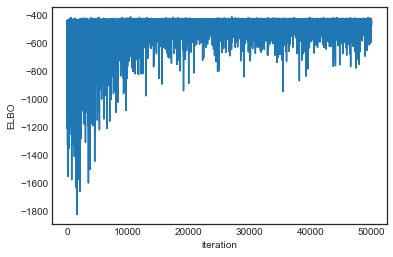

In [24]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [25]:


# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5



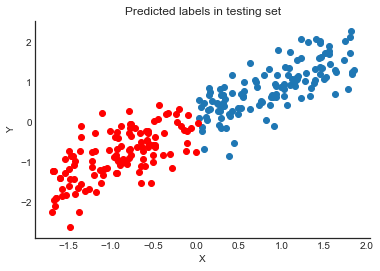

In [26]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [27]:


print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))



Accuracy = 76.8%


In [28]:


grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)



In [29]:


ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)



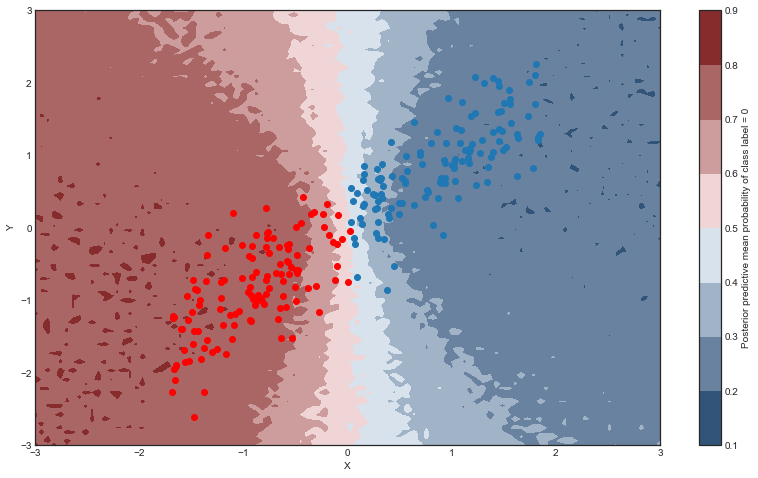

In [30]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');